In [ ]:
import pickle
from pathlib import Path

import getdist as gd
import getdist.plots as gdplots
import matplotlib.pyplot as plt
import numpy as np

from expconfig.synthetic import SynthConfig
from sampling.priors import CompoundPrior

In [2]:
OUTPUTS_PATH = Path().resolve().parent / "outputs"


def get_results_dir(n: int = 0) -> Path:
    """Get the most recent results directory.

    Parameters
    ----------
    n : int, optional
        Index of the results directory to retrieve.
        0 for the most recent, 1 for the second most recent, etc.
        Default is 0.

    Returns
    -------
    Path
        Path to the results directory.
    """
    output_dirs = sorted(
        OUTPUTS_PATH.iterdir(), key=lambda p: p.stat().st_mtime, reverse=True
    )
    return output_dirs[n]

In [ ]:
RESULTS_DIR = get_results_dir(0)

cfg = SynthConfig.load(RESULTS_DIR / "config.yaml")
prior = CompoundPrior.from_dict(cfg.priors.model_dump())
prior_samples = prior.sample(500_000, np.random.default_rng(1234))

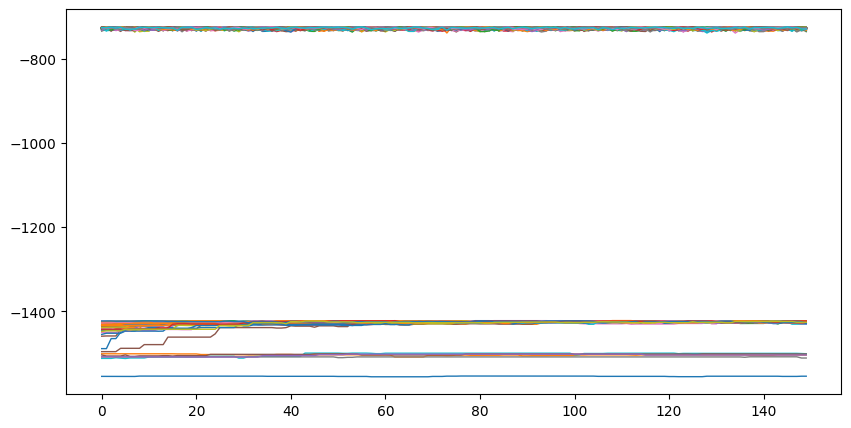

In [4]:
ln_prob = pickle.load(open(RESULTS_DIR / "lnprob_full.pkl", "rb")).reshape(
    -1, cfg.sampling.nwalkers
)
samples = pickle.load(open(RESULTS_DIR / "samples_full.pkl", "rb")).reshape(
    -1, cfg.sampling.nwalkers, prior.n
)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(ln_prob, lw=1)
plt.show()

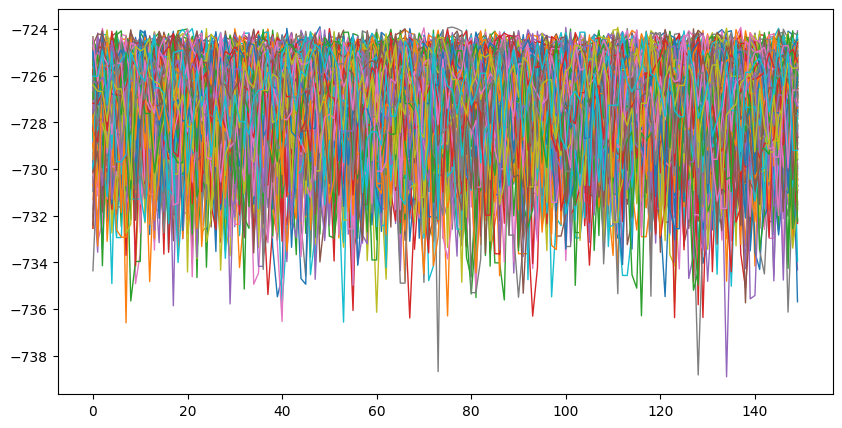

In [5]:
keep_mask = (ln_prob > -800).all(axis=0)
ln_prob = ln_prob[:, keep_mask]
samples = samples[:, keep_mask, :]

with open(RESULTS_DIR / "lnprob.pkl", "wb") as f:
    pickle.dump(ln_prob.reshape(-1), f)
with open(RESULTS_DIR / "samples.pkl", "wb") as f:
    pickle.dump(samples.reshape(-1, prior.n), f)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(ln_prob, lw=1)
plt.show()

Removed no burn in
Removed no burn in


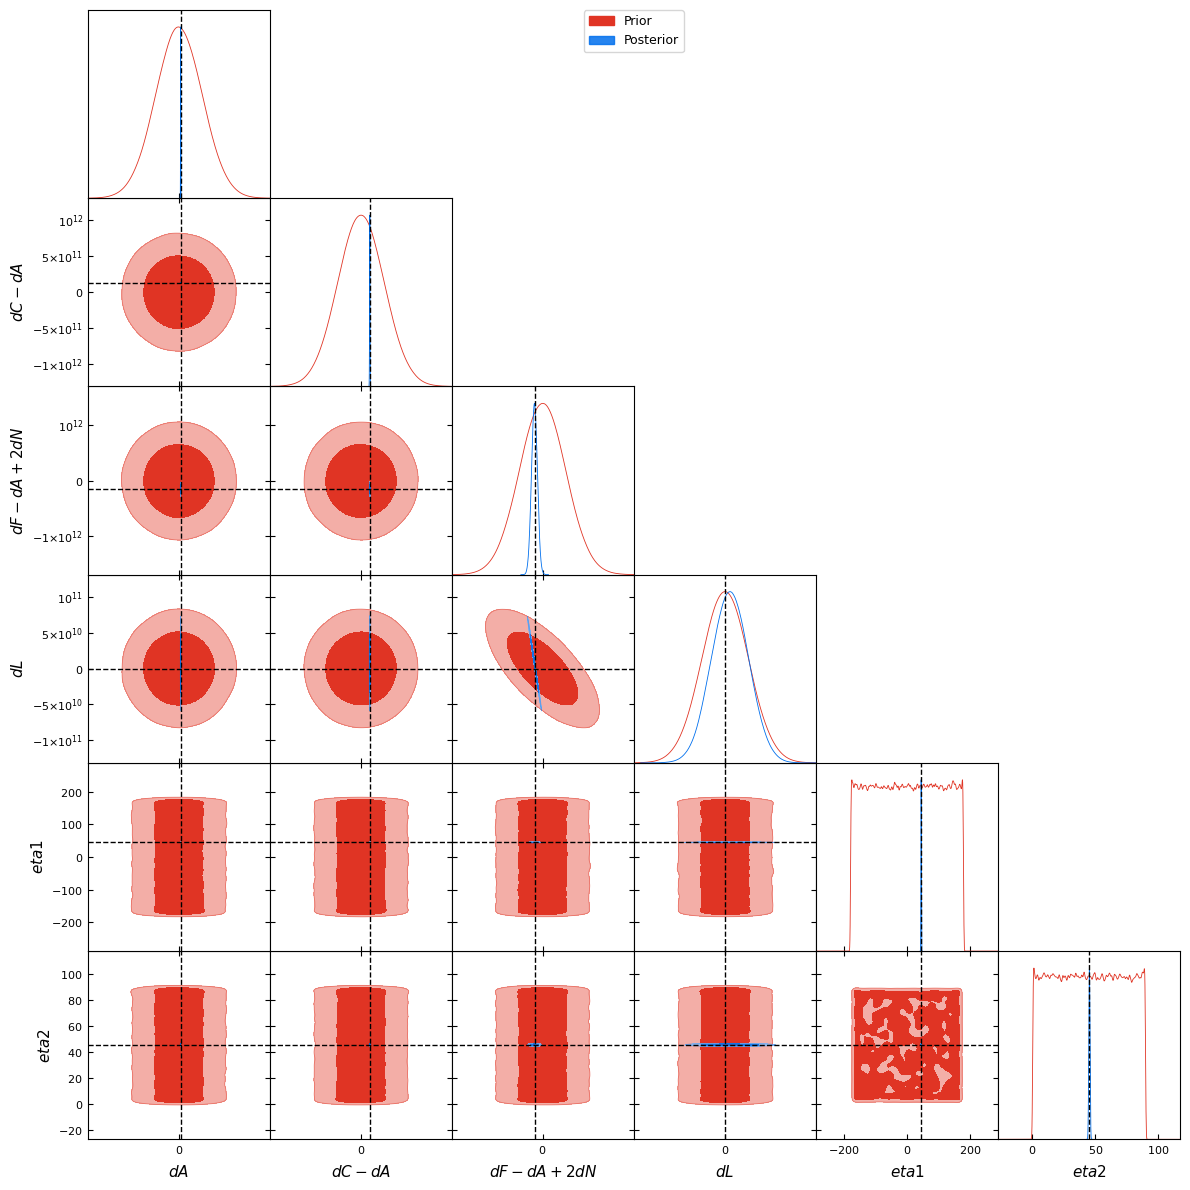

In [7]:
if prior.n == 7:
    names = ["dA", "dC-dA", "dF-dA+2dN", "dL", "dN-dL", "eta1", "eta2"]
    truth = [
        cfg.truth.A,
        cfg.truth.C - cfg.truth.A,
        cfg.truth.F - cfg.truth.A + 2 * cfg.truth.N,
        cfg.truth.L,
        cfg.truth.N - cfg.truth.L,
        cfg.truth.eta1,
        cfg.truth.eta2,
    ]
elif prior.n == 6:
    names = ["dA", "dC-dA", "dF-dA+2dN", "dL", "eta1", "eta2"]
    truth = [
        cfg.truth.A,
        cfg.truth.C - cfg.truth.A,
        cfg.truth.F - cfg.truth.A + 2 * cfg.truth.N,
        cfg.truth.L,
        cfg.truth.eta1,
        cfg.truth.eta2,
    ]
elif prior.n == 5:
    truth = [
        cfg.truth.A,
        cfg.truth.C - cfg.truth.A,
        cfg.truth.F - cfg.truth.A + 2 * cfg.truth.N,
        cfg.truth.eta1,
        cfg.truth.eta2,
    ]
    names = ["dA", "dC-dA", "dF-dA+2dN", "eta2", "eta21"]
else:
    raise ValueError(f"Unsupported number of parameters: {prior.n}")

posterior_samples_gd = gd.MCSamples(
    samples=samples.reshape(-1, prior.n), names=names, labels=names
)
prior_samples_gd = gd.MCSamples(samples=prior_samples, names=names, labels=names)
g = gdplots.getSubplotPlotter()
g.triangle_plot(
    [prior_samples_gd, posterior_samples_gd],
    legend_labels=["Prior", "Posterior"],
    filled=True,
    markers=truth,
    marker_args={"color": "k", "lw": 1},
)

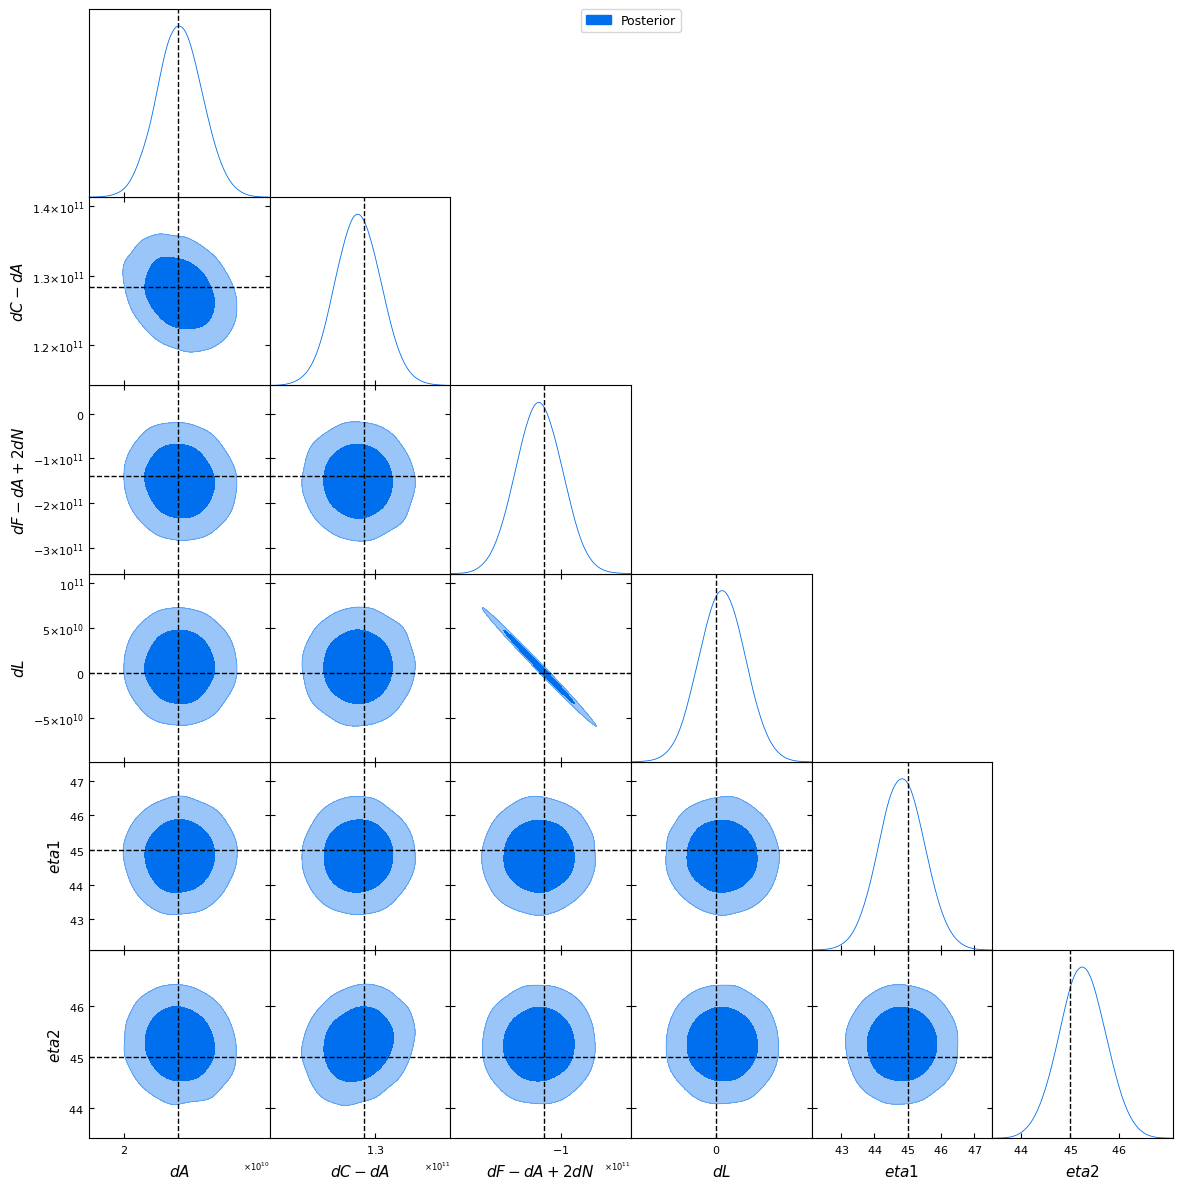

In [8]:
g.triangle_plot(
    [posterior_samples_gd],
    legend_labels=["Posterior"],
    filled=True,
    markers=truth,
    marker_args={"color": "k", "lw": 1},
)

In [ ]:
from sddr.sddr import fit_marginalised_posterior

model = fit_marginalised_posterior(
    posterior_samples_gd.samples,
    np.arange(prior.n),
    cfg.flow,
    cfg.training,
)

Training NF: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


In [10]:
posterior_samples = model.sample(10_000)
# should check that this looks like the marginals above. If I do stick with looking at posterior predictive distributions then should probably do this straight away and then plot the marginals based on these samples?

In [11]:
from expconfig.synthetic import (
    RNG,
    create_paths,
    gaussian_noise_data_max,
)
from icprem import PREM_IC_RHO, PREM_IC_VP
from tti.traveltimes import TravelTimeCalculator

normalisation = -1 / (2 * PREM_IC_RHO * (PREM_IC_VP * 1e3) ** 2)
ic_in, ic_out = create_paths(source_spacing=30.0)
synthetic_data_clean = TravelTimeCalculator(
    ic_in, ic_out, normalisation=normalisation, nested=False, shear=True, N=True
)(cfg.truth.as_array())[0]
noise = gaussian_noise_data_max(cfg.data.noise_level, RNG, synthetic_data_clean)
synthetic_data = synthetic_data_clean + noise

if prior.n == 7:
    include_N = True
elif prior.n == 6:
    include_N = False
ttc = TravelTimeCalculator(
    ic_in, ic_out, normalisation=normalisation, nested=True, shear=True, N=include_N
)
posterior_predictive = ttc(posterior_samples)
posterior_predictive += RNG.normal(  # recreating the noise manually because gaussin_noise_data_max is a bit weird and I want to be sure the noise is the same for the posterior predictive and the synthetic data
    loc=0.0,
    scale=np.abs(synthetic_data_clean).max() * cfg.data.noise_level,
    size=posterior_predictive.shape,
)

# zero perturbation from PREM, PREM is isotropic so all traveltimes are the same
prem_prediction = ttc(np.zeros(prior.n))[0, 0]

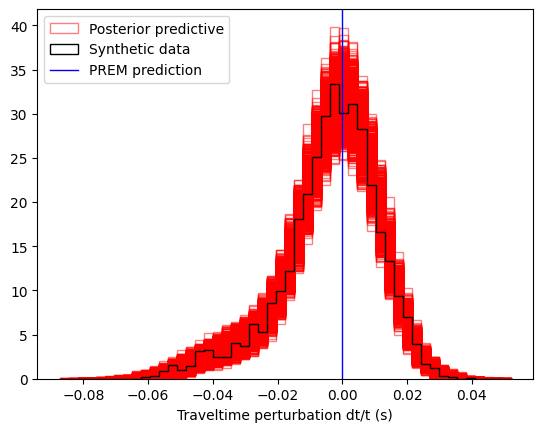

In [12]:
# ensuring that the histogram range is the same for both the posterior predictive and the synthetic data, so that densities are comparable
all_dists = np.vstack([posterior_predictive, synthetic_data[None, :]])
hist_range = (all_dists.min(), all_dists.max())
common_kwargs = {
    "bins": 50,
    "histtype": "step",
    "range": hist_range,
    "density": True,
}
plt.hist(
    posterior_predictive.T,
    **common_kwargs,
    label="Posterior predictive",
    color=np.full(posterior_predictive.shape[0], fill_value="r"),
    alpha=0.5,
)
plt.hist(
    synthetic_data,
    **common_kwargs,
    label="Synthetic data",
    color="k",
)
plt.axvline(prem_prediction, color="b", lw=1, label="PREM prediction")
plt.xlabel("Traveltime perturbation dt/t (s)")
plt.legend()